## **Model Training**

### **Table of Contents**
- [Introduction](#introduction)
- [Step 1: Import libraries](#step-1-import-libraries)
- [Step 2: Configure logging](#step-2-configure-logging)
- [Step 3: Configure MLflow tracking](#step-3-configure-mlflow-tracking)
- [Step 4: Load data and train/test split](#step-4-load-data-and-traintest-split)
- [Step 5: Feature selection with RFE (XGBoost)](#step-5-feature-selection-with-rfe-xgboost)
- [Step 6: (Optional) Re-assert MLflow experiment](#step-6-optional-re-assert-mlflow-experiment)
- [Step 7: Define models and hyperparameter grids](#step-7-define-models-and-hyperparameter-grids)
- [Step 8: Evaluation helper (GridSearchCV + metrics)](#step-8-evaluation-helper-gridsearchcv--metrics)
- [Step 9: Train, compare, and log models](#step-9-train-compare-and-log-models)
- [Step 10: Visualise model metrics](#step-10-visualise-model-metrics)
- [Step 11: Select best model and save config](#step-11-select-best-model-and-save-config)

<a id="introduction"></a>
### **Introduction**

This notebook trains and compares several **regression models** for house price prediction.  
It includes **feature selection** (RFE with XGBoost), **hyperparameter search** (GridSearchCV), **metric reporting** (R², RMSE, MAE), optional **MLflow tracking**, and saving a **model configuration YAML** with the selected features.

<a id="step-1-import-libraries"></a>
### **Step 1: Import libraries**

Load core packages for modelling, evaluation, feature selection, tracking, and plotting:
- `pandas`, `numpy`
- `sklearn` (models, GridSearchCV, metrics, RFE)
- `xgboost` (XGBRegressor)
- `mlflow` (experiment tracking)
- `yaml`, `os`, `logging`, `matplotlib`

In [1]:
# -------------------------------------------------------------
# Step 1: Import libraries
# -------------------------------------------------------------

# Core scientific stack
import pandas as pd
import numpy as np

# Model persistence
import joblib

# Typing and base estimator class
from typing import Dict, Any, Union      
from sklearn.base import BaseEstimator   

# Experiment tracking
import mlflow
import mlflow.sklearn

# Scikit-learn: model selection, models, metrics, feature selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE

# Gradient boosting (XGBoost)
from xgboost import XGBRegressor
import xgboost as xgb

# Utilities and helpers
import yaml
import os
import logging
from contextlib import nullcontext

# Visualisation
import matplotlib.pyplot as plt

<a id="step-2-configure-logging"></a>
### **Step 2: Configure logging**

Set a basic logging configuration to surface progress messages during training and evaluation.

In [2]:
# -------------------------------------------------------------
# Step 2: Configure logging
# -------------------------------------------------------------

# Configure logging to show INFO-level messages and above
logging.basicConfig(level=logging.INFO)

# Create a logger instance for this notebook/module
logger = logging.getLogger()

<a id="step-3-configure-mlflow-tracking"></a>
### **Step 3: Configure MLflow tracking**

Point MLflow at a local tracking server and set the experiment name so that runs, parameters, metrics, and models are recorded.

In [3]:
# -------------------------------------------------------------
# Step 3: Configure MLflow tracking
# -------------------------------------------------------------

# Define where MLflow should log experiments (local server on port 5555)
mlflow_tracking_uri = "http://127.0.0.1:5555"

# Point MLflow to this tracking server
mlflow.set_tracking_uri(mlflow_tracking_uri)

# Set or create the experiment to group related runs
mlflow.set_experiment("House Price Prediction Experiment")

<Experiment: artifact_location='/mlflow/artifacts/1', creation_time=1759504050238, experiment_id='1', last_update_time=1759504050238, lifecycle_stage='active', name='House Price Prediction Experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>

<a id="step-4-load-data-and-traintest-split"></a>
### **Step 4: Load data and train/test split**

Load engineered features from `../data/processed/engineered_features.csv`, split into features/target (`price`) and create train/test partitions with a fixed `random_state` for reproducibility.

In [4]:
# -------------------------------------------------------------
# Step 4: Load data and train/test split
# -------------------------------------------------------------

# Path to the processed dataset containing engineered features
data_path = '../data/processed/engineered_features.csv'  # Update path if needed

# Load the dataset into a DataFrame
data = pd.read_csv(data_path)

# Separate predictors (X) from the target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Split into training and test sets (80/20 split for evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=5901
)

<a id="step-5-feature-selection-with-rfe-xgboost"></a>
### **Step 5: Feature selection with RFE (XGBoost)**

Fit an XGBoost model and use **Recursive Feature Elimination** to select the **top 10** predictive features.  
Print selected vs ignored features and **filter** `X_train`/`X_test` to those selected columns for downstream experiments.  
Store the selection in `selected_features_dict` for later persistence.

In [5]:
# -------------------------------------------------------------
# Step 5: Feature selection with RFE (XGBoost)
# -------------------------------------------------------------

# Initialise an XGBoost regressor (consistent with later modelling)
xgb_model = XGBRegressor(objective='reg:squarederror')

# Fit model on the training data to use inside RFE
xgb_model.fit(X_train, y_train)

# Recursive Feature Elimination (RFE):
# - Iteratively fits the model and removes less important features
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)

# Identify the top 10 selected and the ignored features
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store the selected features for saving into model config later
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter training and test sets to use only the selected features
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]

✅ Top 10 Selected Features by RFE:
 - 0
 - 1
 - 3
 - 4
 - 5
 - 9
 - 10
 - 12
 - 13
 - 14

❌ Features Ignored by RFE:
 - 2
 - 6
 - 7
 - 8
 - 11
 - 15


<a id="step-6-optional-re-assert-mlflow-experiment"></a>
### **Step 6: (Optional) Re-assert MLflow experiment**

Optionally re-set the MLflow tracking URI and experiment (useful in interactive sessions).

In [6]:
# -------------------------------------------------------------
# Step 6: (Optional) Re-assert MLflow experiment
# -------------------------------------------------------------

# In case the MLflow connection is lost or re-run in an interactive session,
# this block ensures the tracking URI and experiment are correctly re-set.
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)  # Point to MLflow server
    mlflow.set_experiment("House Price Prediction Experiment")  # Use the same experiment name


<a id="step-7-define-models-and-hyperparameter-grids"></a>
### **Step 7: Define models and hyperparameter grids**

Prepare a dictionary of candidate regressors:
- Linear Regression
- Random Forest
- Gradient Boosting
- XGBoost

Attach concise **grid searches** for tree-based models and learning-boosting parameters.

In [7]:
# -------------------------------------------------------------
# Step 7: Define models and hyperparameter grids
# -------------------------------------------------------------

# Dictionary of candidate models to compare
models = {
    'LinearRegression': LinearRegression(),                                         # Baseline linear regression
    'RandomForest': RandomForestRegressor(random_state=5901),                       # Bagged decision trees
    'GradientBoosting': GradientBoostingRegressor(random_state=5901),               # Boosted decision trees
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=5901)    # XGBoost regressor
}

# Hyperparameter grids for each model to tune using GridSearchCV
model_grids = {
    'LinearRegression': {},  # No hyperparameters to tune here

    'RandomForest': {
        'n_estimators': [100, 200, 300],    # Number of trees
        'max_depth': [None, 10, 20, 30],    # Maximum depth of each tree
        'min_samples_split': [2, 5, 10],    # Minimum samples required to split
        'min_samples_leaf': [1, 2, 4],      # Minimum samples required at a leaf node
        'max_features': ['auto', 'sqrt']    # Number of features to consider at each split
    },

    'GradientBoosting': {
        'n_estimators': [100, 250, 500],    # Number of boosting stages
        'learning_rate': [0.1, 0.05, 0.01], # Shrinkage applied at each step
        'max_depth': [3, 5, 10],            # Depth of individual trees
        'subsample': [0.8, 1.0],            # Fraction of samples used for fitting
        'min_samples_split': [2, 5],        # Min samples to split a node
        'min_samples_leaf': [1, 2]          # Min samples at a leaf
    },

    'XGBoost': {
        'n_estimators': [100, 250, 500],    # Number of boosting rounds
        'learning_rate': [0.1, 0.05, 0.01], # Step size shrinkage
        'max_depth': [3, 5, 10],            # Maximum depth of a tree
        'subsample': [0.8, 1.0],            # Fraction of samples for training
        'colsample_bytree': [0.8, 1.0],     # Fraction of features per tree
        'gamma': [0, 1]                     # Minimum loss reduction for a split
    }
}

<a id="step-8-evaluation-helper-gridsearchcv--metrics"></a>
### **Step 8: Evaluation helper (GridSearchCV + metrics)**

Define `evaluate_model_with_gridsearch`:
- Runs GridSearchCV when a grid is provided (3-fold, scoring = R²)  
- Fits, predicts on test set  
- Returns **MAE**, **MSE**, **RMSE**, **R²**, the **best model**, and **best params**

In [8]:
# -------------------------------------------------------------
# Step 8: Evaluation helper (GridSearchCV + metrics)
# -------------------------------------------------------------

def evaluate_model_with_gridsearch(
    name: str,
    model: BaseEstimator,
    grid: Dict[str, list],
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series
) -> Dict[str, Union[float, BaseEstimator, Dict[str, Any]]]:
    """
    Fit a model with optional GridSearchCV hyperparameter tuning,
    evaluate it on the test set, and return key metrics and the fitted model.

    Parameters
    ----------
    name : str
        Name of the model (for logging and identification).
    model : BaseEstimator
        A scikit-learn compatible estimator.
    grid : dict
        Hyperparameter grid for GridSearchCV. If empty, the model is trained without tuning.
    X_train : pd.DataFrame
        Training feature set.
    y_train : pd.Series
        Training target values.
    X_test : pd.DataFrame
        Test feature set.
    y_test : pd.Series
        Test target values.

    Returns
    -------
    dict
        Dictionary containing:
        
        - 'mae' : float  
          Mean Absolute Error on test set.  
        - 'mse' : float  
          Mean Squared Error on test set.  
        - 'rmse' : float  
          Root Mean Squared Error on test set.  
        - 'r2' : float  
          R² score on test set.  
        - 'model' : BaseEstimator  
          The best fitted model (with tuned or default parameters).  
        - 'params' : dict  
          Best parameters found by GridSearchCV, or the model's parameters if no tuning.  
    """
    
    if grid:
        # Perform grid search with cross-validation (3-fold, scoring by R²)
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_   # Best model after tuning
        best_params = clf.best_params_     # Best hyperparameters
    else:
        # If no grid provided, just fit the base model
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)   # Mean Absolute Error
    mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
    rmse = np.sqrt(mse)                         # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)               # Coefficient of Determination (R²)

    # Return results in a structured dictionary
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

# Confirm MLflow tracking URI is set correctly
print("MLflow tracking URI:", mlflow_tracking_uri)

MLflow tracking URI: http://127.0.0.1:5555


<a id="step-9-train-compare-and-log-models"></a>
### **Step 9: Train, compare, and log models**

Loop through the model zoo:
- Train/evaluate each (with grid search where applicable)  
- Collect metrics in `results`  
- If MLflow is configured, **log params, metrics, and the fitted model** (nested runs per model)

This yields a like-for-like comparison across algorithms.

In [9]:
# -------------------------------------------------------------
# Step 9: Train, compare, and log models
# -------------------------------------------------------------

# Dictionary to hold evaluation results for each model
results = {}

# Start a parent MLflow run for the overall model comparison
with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():
    
    # Loop through each candidate model
    for name, model in models.items():
        logger.info(f"Training {name}...")
        
        # Start a nested MLflow run for this specific model (if tracking is enabled)
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            
            # Train and evaluate the model (with GridSearchCV if applicable)
            evaluation = evaluate_model_with_gridsearch(
                name, model, model_grids[name], X_train, y_train, X_test, y_test
            )
            
            # Store results in the dictionary
            results[name] = evaluation

            # Log parameters, metrics, and model to MLflow if tracking is active
            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],   # Mean Absolute Error
                    'mse': evaluation['mse'],   # Mean Squared Error
                    'rmse': evaluation['rmse'], # Root Mean Squared Error
                    'r2': evaluation['r2']      # R² Score
                })
                mlflow.sklearn.log_model(
                    evaluation['model'],
                    artifact_path=name.lower().replace(" ", "_")  # Save with lowercase name
                )
            
            # Print quick summary of performance for reference
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


INFO:root:Training LinearRegression...
2025/10/03 17:00:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 17:00:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/03 17:00:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Training RandomForest...


LinearRegression R2: 0.9954, RMSE: 17351.46
🏃 View run LinearRegression at: http://127.0.0.1:5555/#/experiments/1/runs/8351362901ca41559f98eadcf73fbbbc
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


c:\Users\HP\OneDrive\Documents\Projects\MLOps\MLOps-House-Price-Prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\HP\OneDrive\Documents\Projects\MLOps\MLOps-House-Price-Prediction\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\OneDrive\Documents\Projects\MLOps\MLOps-House-Price-Prediction\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrappe

RandomForest R2: 0.9830, RMSE: 33176.05
🏃 View run RandomForest at: http://127.0.0.1:5555/#/experiments/1/runs/5f290bc9135b4b329e0b3a0d9dba62ca
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


2025/10/03 17:00:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 17:00:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/03 17:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Training XGBoost...


GradientBoosting R2: 0.9964, RMSE: 15307.33
🏃 View run GradientBoosting at: http://127.0.0.1:5555/#/experiments/1/runs/6170ec75cfc6454b9b325145d587111e
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


2025/10/03 17:00:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 17:01:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/10/03 17:01:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost R2: 0.9629, RMSE: 49089.74
🏃 View run XGBoost at: http://127.0.0.1:5555/#/experiments/1/runs/ec7a06888e624558a245ac6e1a5112d8
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1
🏃 View run model_comparison at: http://127.0.0.1:5555/#/experiments/1/runs/8683c1aa76d743ae9248d9d918ba3a05
🧪 View experiment at: http://127.0.0.1:5555/#/experiments/1


<a id="step-10-visualise-model-metrics"></a>
### **Step 10: Visualise model metrics**

Bar plots to compare models by metric (`R²`, `RMSE`, `MAE`), aiding quick identification of the best-performing approach.

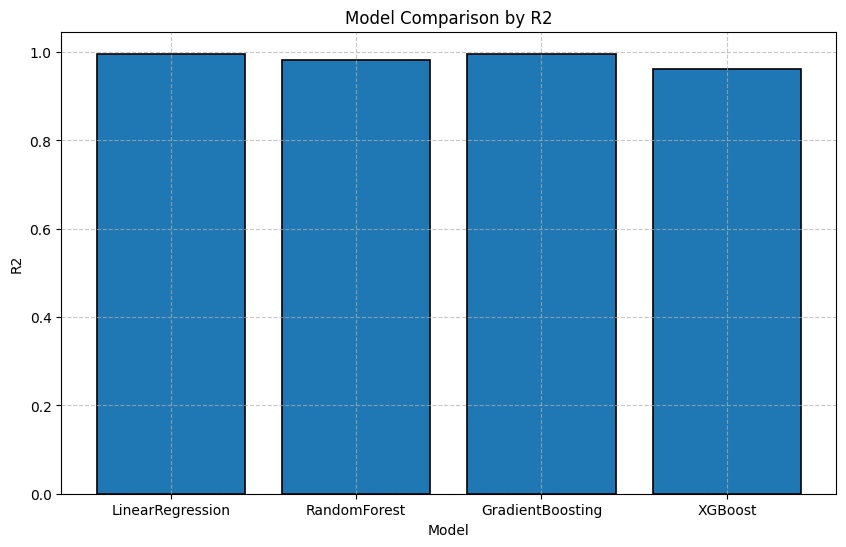

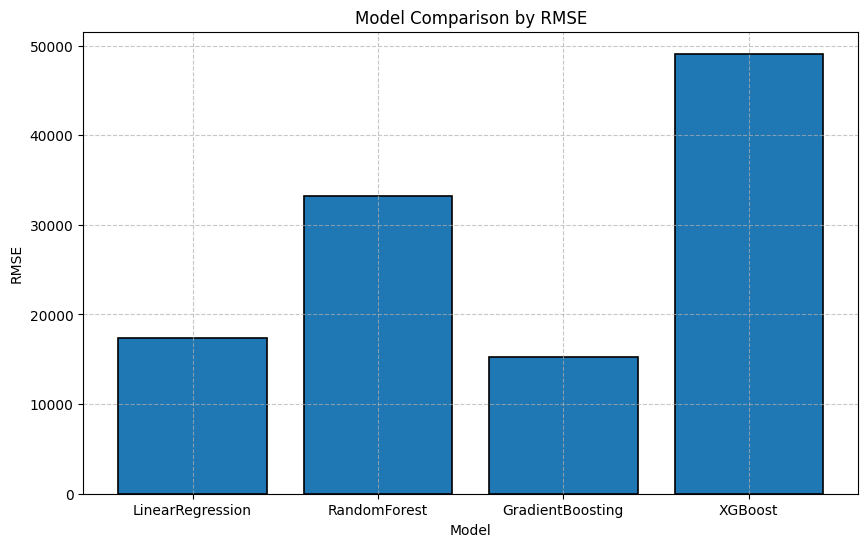

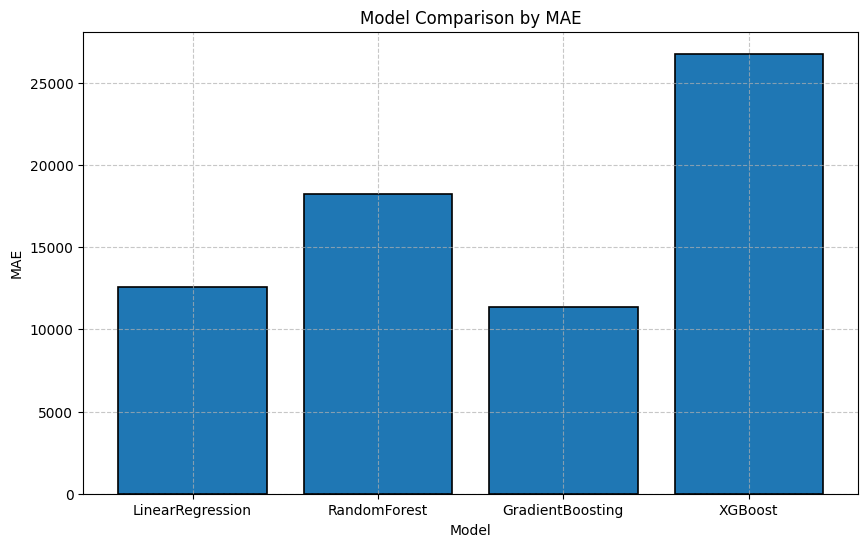

In [10]:
# -------------------------------------------------------------
# Step 10: Visualise model metrics
# -------------------------------------------------------------

def plot_model_metrics(results, metric='r2'):
    """
    Plot a bar chart comparing model performance on a given metric.
    Metrics can be 'r2', 'rmse', 'mae', or 'mse'.
    """

    # Extract model names and their corresponding metric values
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    # Create a bar chart with black outlines around bars
    plt.figure(figsize=(10, 6))
    plt.bar(names, values, edgecolor='black', linewidth=1.2)

    # Add labels, title, and grid for readability
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

# Example usage of the visualisation function:
plot_model_metrics(results, metric='r2')   # Compare by R²
plot_model_metrics(results, metric='rmse') # Compare by RMSE
plot_model_metrics(results, metric='mae')  # Compare by MAE

<a id="step-11-select-best-model-and-save-config"></a>
### **Step 11: Select best model and save config**

Pick the **best model** by highest **R²**, print a summary, then write a **YAML config** to `../configs/model_config.yaml` including:
- Best model name and parameters  
- Metrics (R², MAE, RMSE)  
- Target variable  
- The **RFE-selected feature set** (`selected_features_dict`)  

This config can drive downstream inference or deployment steps.

In [11]:
# -------------------------------------------------------------
# Step 11: Select best model and save config
# -------------------------------------------------------------

# Identify the best model by highest R² score
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()

# Extract key performance metrics
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

# Print a summary of the best model’s performance
print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

# Build configuration dictionary to save model metadata
model_config = {
    'model': {
        'name': 'house_price_model',            # Project-level model identifier
        'best_model': best_model_name,          # Best performing algorithm
        'parameters': best_params,              # Best hyperparameters
        'r2_score': best_r2,                    # Performance metrics
        'mae': best_mae,
        'target_variable': 'price',             # Target variable name
        'feature_sets': selected_features_dict  # Features chosen by RFE
    }
}

# Ensure configs directory exists and save as YAML file
config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"✅ Saved model config to {config_path}")

🏆 Best Model: GradientBoosting
   R² Score: 0.9964
   MAE: 11363.09
   RMSE: 15307.33
✅ Saved model config to ../configs/model_config.yaml
